In [2]:
import torch
import torch.backends.cudnn as cudnn
from craft import CRAFT
from refinenet import RefineNet
import cv2
import numpy as np
import os
from collections import OrderedDict
import craft_utils
import imgproc
import file_utils
from PIL import Image

In [3]:
def copyStateDict(state_dict):
    if list(state_dict.keys())[0].startswith("module"):
        start_idx = 1
    else:
        start_idx = 0
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = ".".join(k.split(".")[start_idx:])
        new_state_dict[name] = v
    return new_state_dict

In [4]:
import os

os.getcwd()

'c:\\Users\\anial\\Downloads\\capstone-htr\\CRAFT-pytorch'

In [5]:
use_cuda = torch.cuda.is_available()
trained_model_path = "./weights/craft_mlt_25k.pth"
refiner_model_path = "./weights/craft_refiner_CTW1500.pth"

In [6]:
canvas_size = 1280
mag_ratio = 1.5
text_threshold = 0.7
low_text = 0.4
link_threshold = 0.4

In [7]:
detector = CRAFT()
detector.load_state_dict(
    copyStateDict(
        torch.load(trained_model_path, map_location="cuda" if use_cuda else "cpu")
    )
)
detector = detector.cuda() if use_cuda else detector
detector = torch.nn.DataParallel(detector)
cudnn.benchmark = False
detector.eval()

c:\Users\anial\Downloads\capstone-htr\craft\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\anial\Downloads\capstone-htr\craft\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\anial\AppData\Local\Temp\ipykernel_19568\211447847.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default va

DataParallel(
  (module): CRAFT(
    (basenet): vgg16_bn(
      (slice1): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (9): ReLU(inplace=True)
        (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (slice2): Sequential(


In [8]:
refine_net = RefineNet()
refine_net.load_state_dict(
    copyStateDict(
        torch.load(refiner_model_path, map_location="cuda" if use_cuda else "cpu")
    )
)
refine_net = refine_net.cuda() if use_cuda else refine_net
refine_net = torch.nn.DataParallel(refine_net)
refine_net.eval()

C:\Users\anial\AppData\Local\Temp\ipykernel_19568\2070395983.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  refine_net.load_state_dict(copyStateDict(torch.load(refiner_

DataParallel(
  (module): RefineNet(
    (last_conv): Sequential(
      (0): Conv2d(34, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (aspp1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(6, 6), dilation=(6, 6))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (4): BatchNorm2d(128, e

In [86]:
import matplotlib.pyplot as plt
import importlib
import inference

importlib.reload(inference)
from inference import draw_boxes, run_craft_inference, simple_merge_boxes

In [82]:
image_path = "test_picture.jpg"
img, detected_boxes = run_craft_inference(
    image_path, net=detector, refine_net=refine_net, link_threshold=0.7
)
output_img = draw_boxes(img, detected_boxes)

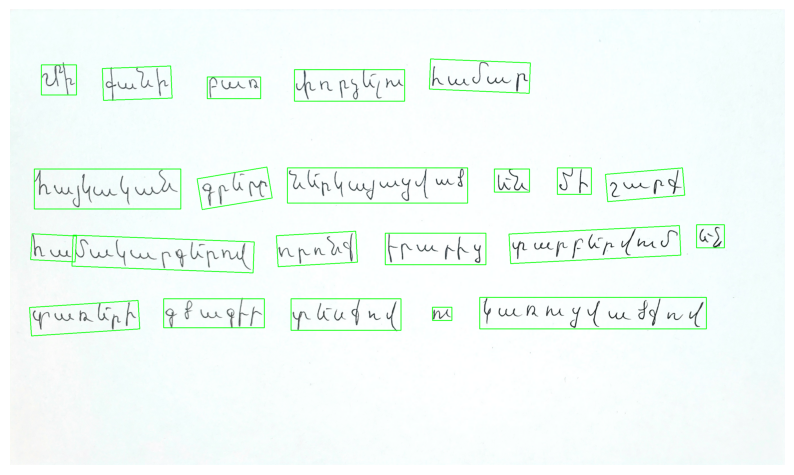

In [83]:
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

### Postprocessing the detected boxes

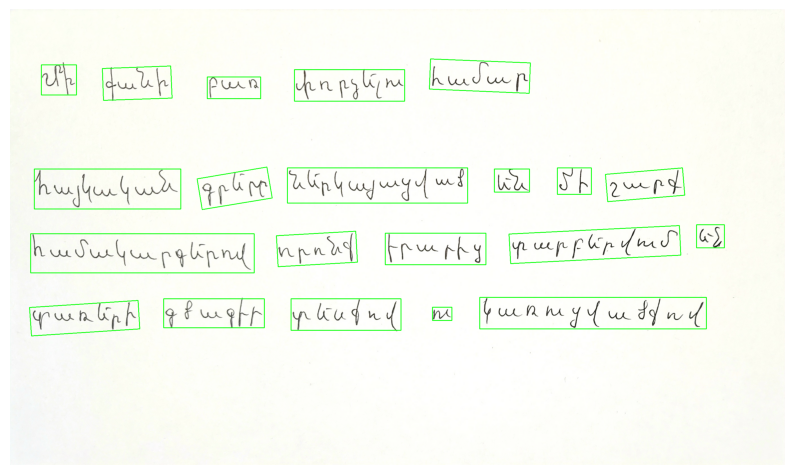

In [ ]:
refined_boxes = merge_boxes(detected_boxes)
output_img = draw_boxes(img, refined_boxes)
plt.figure(figsize=(10, 10))
plt.imshow(output_img)
plt.axis("off")
plt.show()

In [ ]:
img_pil = Image.open(image_path)
print(img_pil._getexif())

{256: 1620, 257: 2756, 34853: {3: 'E', 4: (0.0, 0.0, 0.0)}, 34665: 200, 271: 'samsung', 272: 'SM-S908E', 274: 8, 306: '2025:04:07 19:16:23', 531: 1, 282: 72.0, 283: 72.0, 36864: '0220', 40961: 1, 40962: 1620, 36867: '2025:04:07 19:16:23', 36868: '2025:04:07 19:16:23', 37380: 0.0, 40963: 2756, 41987: 0, 37384: 0, 37385: 0, 37386: 6.4, 41989: 23, 36880: '+04:00', 36881: '+04:00', 33434: 0.0099, 33437: 1.8, 34855: 320}
